## Исследование авиакомпаниии

    
Настоящий проект демонстрирует навыки:
* получения данных из открытых источников Интернет;
* применения технологии HTTP **_API_**;
* обработки данных скриптами на языке SQL, использование операторов **_Select_** и **_Join_**;
* выполнения операций с базой: импорт, экспорт данных;
* построение графиков с помощью библиотек **_matplotlib_** и  **_Seaborn_**
* построения интерактивных карт с помощью библиотеки **_Plotly Mapbox_**


## Задание


С помощью SQL-запросов необходимо получить два файла,  проверить данные на корректность, изучить и визуализировать их.
    

## План проекта

   1. Сформировать SQL- запросы
   2. Выгрузить полученные на предыдущих шагах файлы, изучить их.
   3. Визуализировать данные о моделях самолетов и количества выполняемых ими рейсов.
   4. Визуализировать данные городов по количеству рейсов.
   5. Визуализировать данные топ-10 городов по количеству рейсов.
   6. При необходимости провести дополнительные исследования.
   7. Подготовить общие выводы.

## 1. SQL - запросы

### 1.1. Найдем количество рейсов на каждой модели самолёта с вылетом в сентябре 2018 года

**SELECT**
    
    DISTINCT aircrafts.model AS model,
    COUNT(flights.flight_id) AS flights_amount
    
**FROM**
    
    aircrafts
    INNER JOIN flights ON flights.aircraft_code = aircrafts.aircraft_code

**WHERE**
    
    EXTRACT(MONTH FROM flights.departure_time) = '9'

**GROUP BY**
    
    model;

### 1.2. Произведем расчет среднего количества прибывающих в августе 2018 года  рейсов в день, для каждого города.

**SELECT**
    
    SUBQ.city AS city,
    AVG(SUBQ.flight_id) AS average_flights
**FROM**

**(**

    SELECT
        
        airports.city AS city,
        EXTRACT(DAY FROM flights.arrival_time) AS day,
        COUNT(flights.flight_id) AS flight_id
    
    FROM
        flights
    
    INNER JOIN airports ON airports.airport_code = flights.arrival_airport
    WHERE
        EXTRACT(MONTH FROM flights.arrival_time) = '8'
    GROUP BY
        day,
        city

**)** AS SUBQ

**GROUP BY**
    
    city;

### 1.3 Вывод:

С помощью SQL запросов получили требуемые для исследования срезы данных.

## 2. Работа с данными

Для реализации проекта импортируем все необходимые библиотеки.

In [221]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline

from datetime import datetime
from scipy import stats as st

import pandas as pd
import requests
from bs4 import BeautifulSoup

from IPython.display import HTML, display

import plotly.express as px
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

from io import BytesIO
import geocoder
import requests
import json

Интерактивные графики используют **JavaScript**, подключим наш блокнот следующим скриптом:

In [259]:
init_notebook_mode(connected=True)

### 2.1. Изучение данных из файлов.   

**Откроем первый файл с данными**, для чтения файла **_csv_** используем готовую функцию библиотеки **_Pandas_** - метод **_read_csv()_**. В качестве имени переменной используем имя датасета **_'model'_**.

In [223]:
path = 'C:\DATA_SET\Project\Project_5/'

try:
    model = pd.read_csv(path + 'query_1.csv')
except:
    model = pd.read_csv('/datasets/query_1.csv')

Создадим функцию **_view_dataset_info_** для получения общей информации о наборах.

In [224]:
def view_dataset_info(df):
    for name in df:
        df.name = 'df'
        #print ('\033[1;30;47m - - - - - - - НАБОР ДАННЫХ \033[0;0m', '\033[1;30;47m {} - - - - - \033[0;0m'.format(name))
        print ('\033[1;30;47m        НАБОР ДАННЫХ:  "{}"       \033[0;0m'.format(name))
        print ('')
        print ('')
        print ('\033[1;30;47m Общая свсодка по набору данных: \033[0;0m')
        display (df.info(memory_usage='deep'))
        print ('')
        print ('\033[1;30;47m Названия столбцов: \033[0;0m')
        display(list(df.columns))
        print ('')
        print ('\033[1;30;47m Подсчет пропусков: \033[0;0m')
        display (df.isnull().sum())
        print ('')
        print (('\033[1;30;47m Количество дубликатов в наборе: \033[0;0m'),
            '   ', df.duplicated().sum(),
            ' - ', round((df.duplicated().sum() / len(df) * 100), 2),
            '%'
        )
        print ('')
        print('\033[1;30;47m Общая сводка строковых значений: \033[0;0m')
        display(df.describe(include=['object']).T)
        print ('')
        print ('\033[1;30;47m Общая сводка числовых значений: \033[0;0m')
        display (df.describe())
        print ('')
        print ('\033[1;30;47m Вывод первых строк набора: \033[0;0m')
        display (df.head())
        print ('')
        print ('')
        return print ('\033[01;30;47m       ОКОНЧАНИЕ ОТЧЕТА        \033[0;0m')

In [225]:
view_dataset_info(model)

        НАБОР ДАННЫХ:  "model"       


 Общая свсодка по набору данных: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   model           8 non-null      object
 1   flights_amount  8 non-null      int64 
dtypes: int64(1), object(1)
memory usage: 775.0 bytes


None


 Названия столбцов: 


['model', 'flights_amount']


 Подсчет пропусков: 


model             0
flights_amount    0
dtype: int64


 Количество дубликатов в наборе:      0  -  0.0 %

 Общая сводка строковых значений: 


,count,unique,top,freq
model,8,8,Boeing 737-300,1



 Общая сводка числовых значений: 


,flights_amount
count,8.000000
mean,2035.625000
std,1965.203947
min,300.000000
25%,605.250000
50%,795.000000
75%,4250.250000
max,4557.000000



 Вывод первых строк набора: 


,model,flights_amount
0,Airbus A319-100,607
1,Airbus A321-200,960
2,Boeing 737-300,630
3,Boeing 767-300,600
4,Boeing 777-300,300




       ОКОНЧАНИЕ ОТЧЕТА        


**Результат осмотра набора данных**:

Набор данных состоит из 2 столбцов и 8 строк: 

 * столбец **_'model'_** содержит строковые значения (8 моделей авиалайнеров),
 * столбец **_'flights_amount'_** содержит целочисленные значения (количество рейсов, выполненных каждой моделью авиалайнеров).

Пропуски, некорректные значения отсутствуют. Предобработка не требуется.

**Откроем второй файл с данными**. В качестве имени переменной используем имя датасета **_'city'_**.

In [226]:
try:
    cities = pd.read_csv(path + 'query_3.csv')
except:
    cities = pd.read_csv('/datasets/query_3.csv')

Ознакомимся с общей информацией о наборе.

In [227]:
view_dataset_info(cities)

        НАБОР ДАННЫХ:  "city"       


 Общая свсодка по набору данных: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   city             101 non-null    object 
 1   average_flights  101 non-null    float64
dtypes: float64(1), object(1)
memory usage: 10.7 KB


None


 Названия столбцов: 


['city', 'average_flights']


 Подсчет пропусков: 


city               0
average_flights    0
dtype: int64


 Количество дубликатов в наборе:      0  -  0.0 %

 Общая сводка строковых значений: 


,count,unique,top,freq
city,101,101,Краснодар,1



 Общая сводка числовых значений: 


,average_flights
count,101.000000
mean,5.494189
std,13.119790
min,1.000000
25%,2.000000
50%,3.000000
75%,5.870968
max,129.774194



 Вывод первых строк набора: 


,city,average_flights
0,Абакан,3.870968
1,Анадырь,1.000000
2,Анапа,2.161290
3,Архангельск,5.354839
4,Астрахань,2.451613




       ОКОНЧАНИЕ ОТЧЕТА        


**Результат осмотра набора**:

Набор данных состоит из 2 столбцов и 101 строки: 

 * столбец **_'city'_** содержит строковые значения (101 город, в котором есть аэропорты),
 * столбец **_'average_flights'_** содержит вещественные значения (среднее количество ежедневно прибывающих рейсов).

Пропуски, некорректные значения отсутствуют. Предобработка не требуется.

Округлим до целого числа значения количества рейсов и приведем к целочисленному типу данные столбца **_'average_flights'_**

In [228]:
cities.average_flights = cities.average_flights.round(0).astype('int64')

In [229]:
cities.head(5)

,city,average_flights
0,Абакан,4
1,Анадырь,1
2,Анапа,2
3,Архангельск,5
4,Астрахань,2


### 2.2. Вывод:

В этот раз с данными повезло.

## 3 Построение графиков

### 3.1 Строим график "Модели лайнеров и количество рейсов".

Учитывая малый размер содержимого набора данных, для визуализации степени участия каждой модели лайнеров в общей перевозке пассажиров за август 2018 года, построим простой столбчатый график методом **_plot()_**

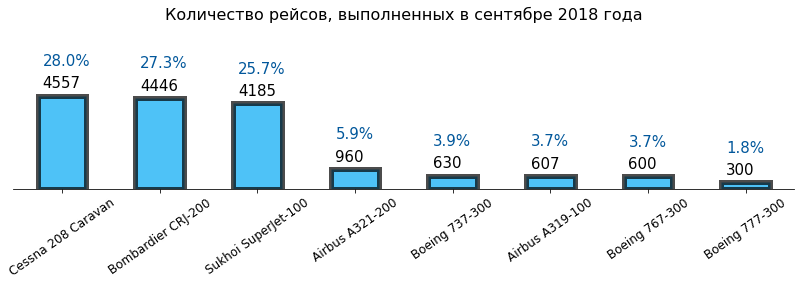

In [230]:
ax = model.sort_values(by='flights_amount', ascending=False).plot(
    kind='bar', x='model', y='flights_amount', figsize=(14, 3),  
    color='#03A9F4', fontsize=14, alpha=0.7, ec='black', linewidth=5, legend=False)
sns.despine(left=True)

totals = []
for i in ax.patches:
    ax.text(i.get_x()+.05, i.get_height()+400,
            str(round((i.get_height()))), fontsize=15, color='black', rotation=0)
    totals.append(i.get_height())
total = sum(totals)
for i in ax.patches:
    ax.text(i.get_x()+.05, i.get_height()+1500,
            str(round((i.get_height()/total)*100, 1))+'%', fontsize=15, color='#01579B')
plt.xticks(rotation=35, fontsize=12)
plt.yticks([])
plt.xlabel('', rotation=0, fontsize=14)
plt.title('Количество рейсов, выполненных в сентябре 2018 года', fontsize=16)
plt.ylim(0, 8000)
plt.show()

### 3.2. Вывод:

Из вышеуказанных данных сследует, что в сентябре 2018 года наибольшее количество рейсов выполнено тремя моделями лайнеров: **_Cessna 208 Caravan_** , **_Bombardier CRJ-200_** и **_Sukhoi SuperJet-100_** - 4557, 4446 и 4185 рейсов соответственно.  На трех лидеров приходится 81 % общих перевозок. Если по **_Bombardier CRJ-200_** и **_Sukhoi SuperJet-100_** вопросов нет, то **нахождение среди лидеров авиатранспортного средства малой пассажировместимости** несколько неожиданно. 
Значительно меньше рейсов выполнено лайнерами **_Airbus_** и **_Boeing_**. На оставшиеся 5 моделей приходится 19 % общих перевозок, что в 4 раза меньше, чем у лидеров.

### 3.3. Ознакомимся с характеристиками лидеров нашей выборки

#### 3.3.1. Американский региональный, ближнемагистральный / узкофюзеляжный самолет _Cessna Caravan_

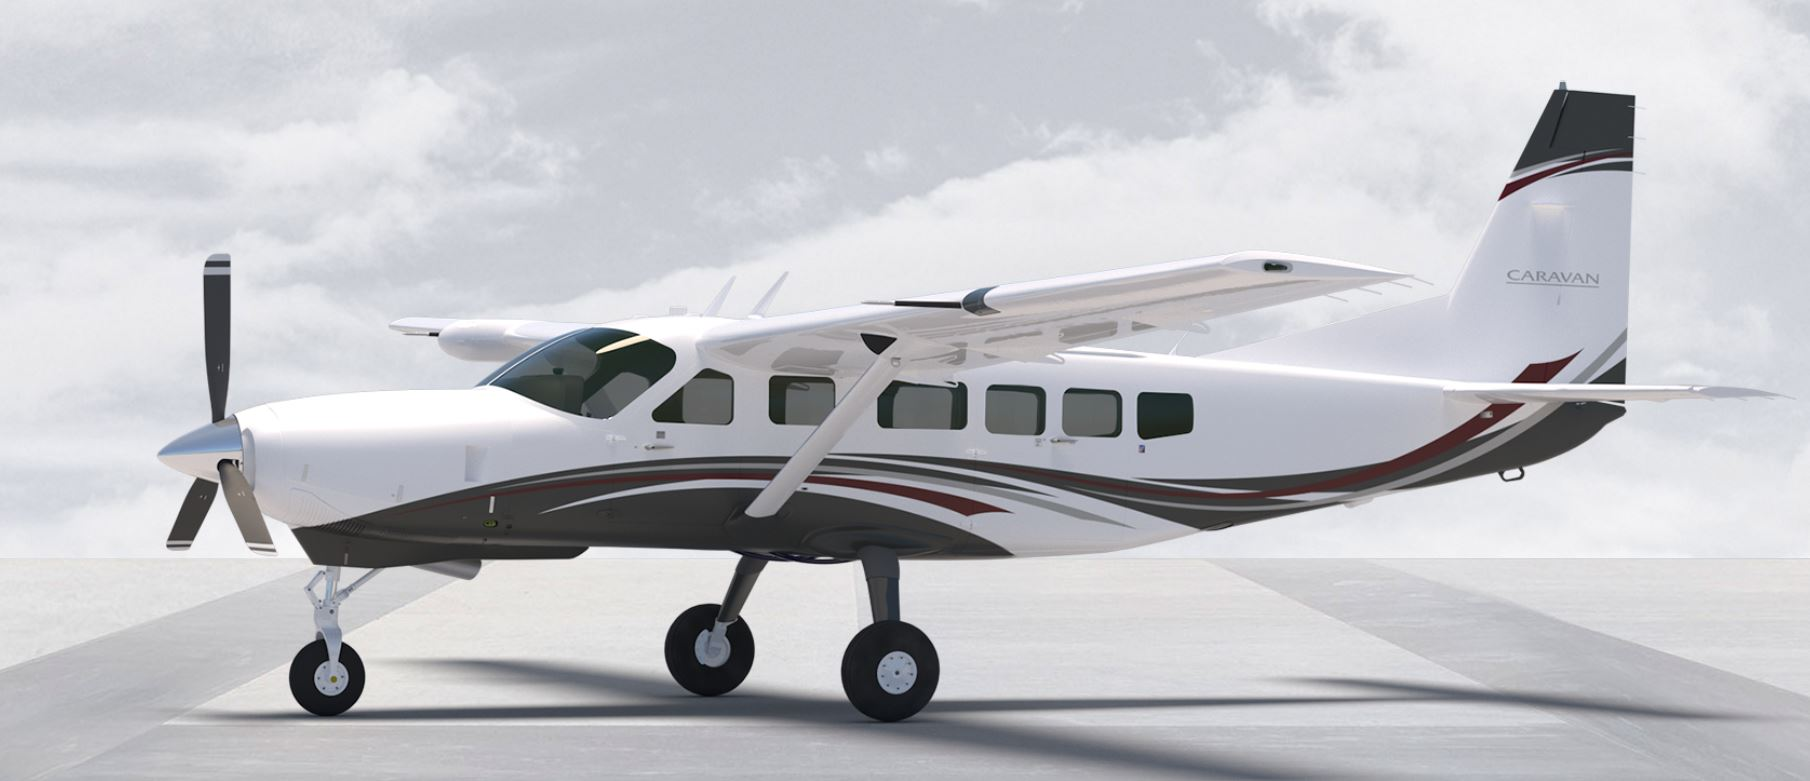

Вид места пилота

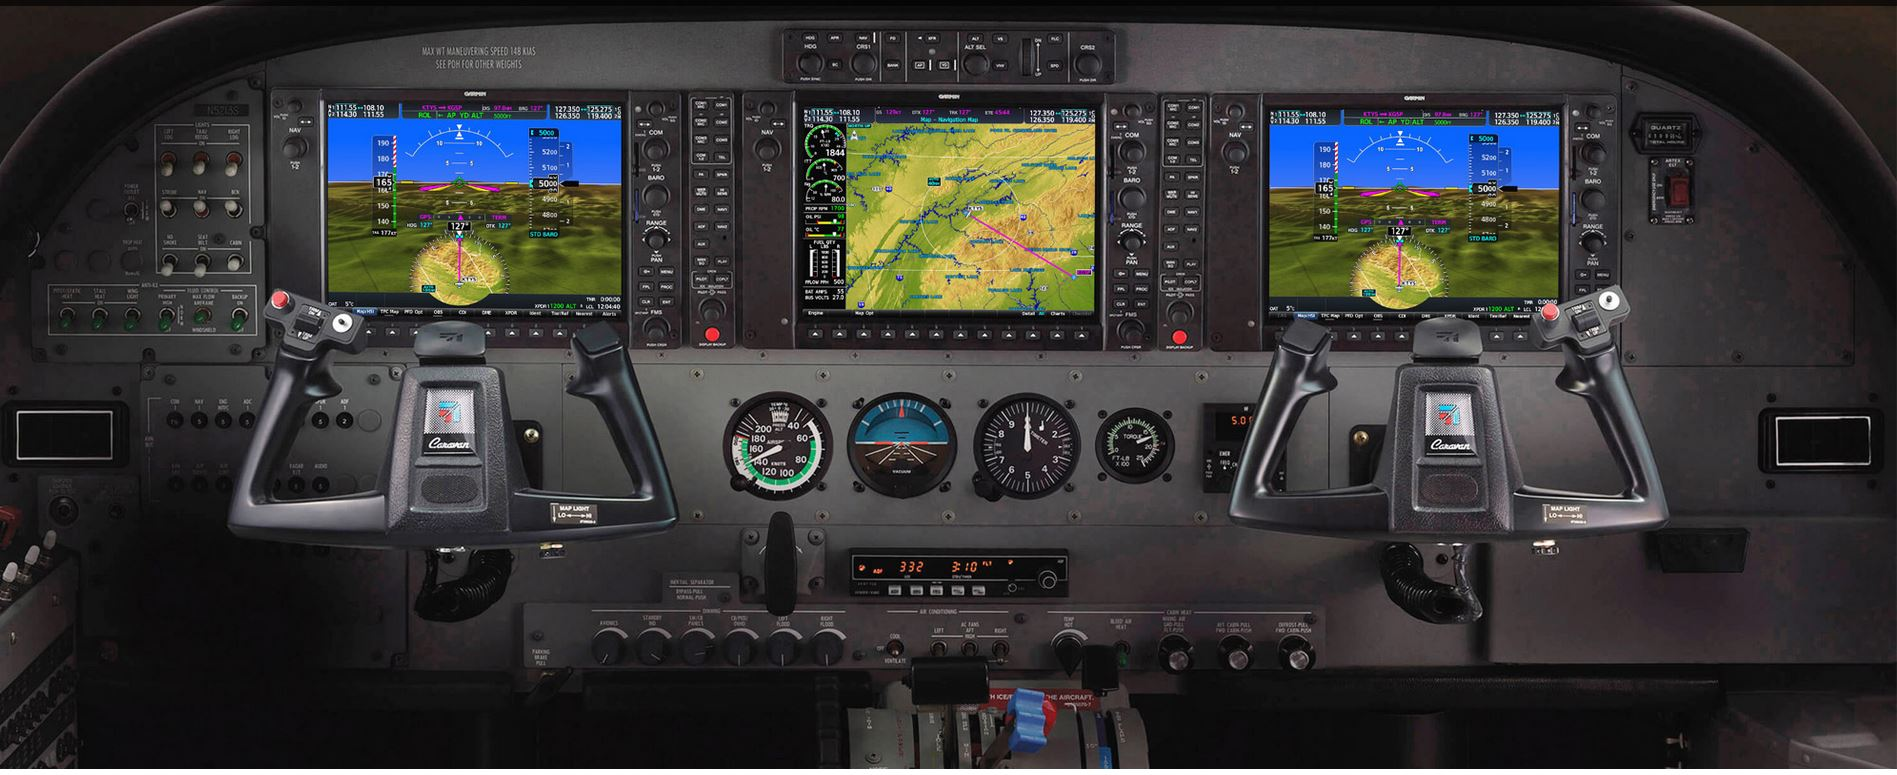

Вид пассажирского салона

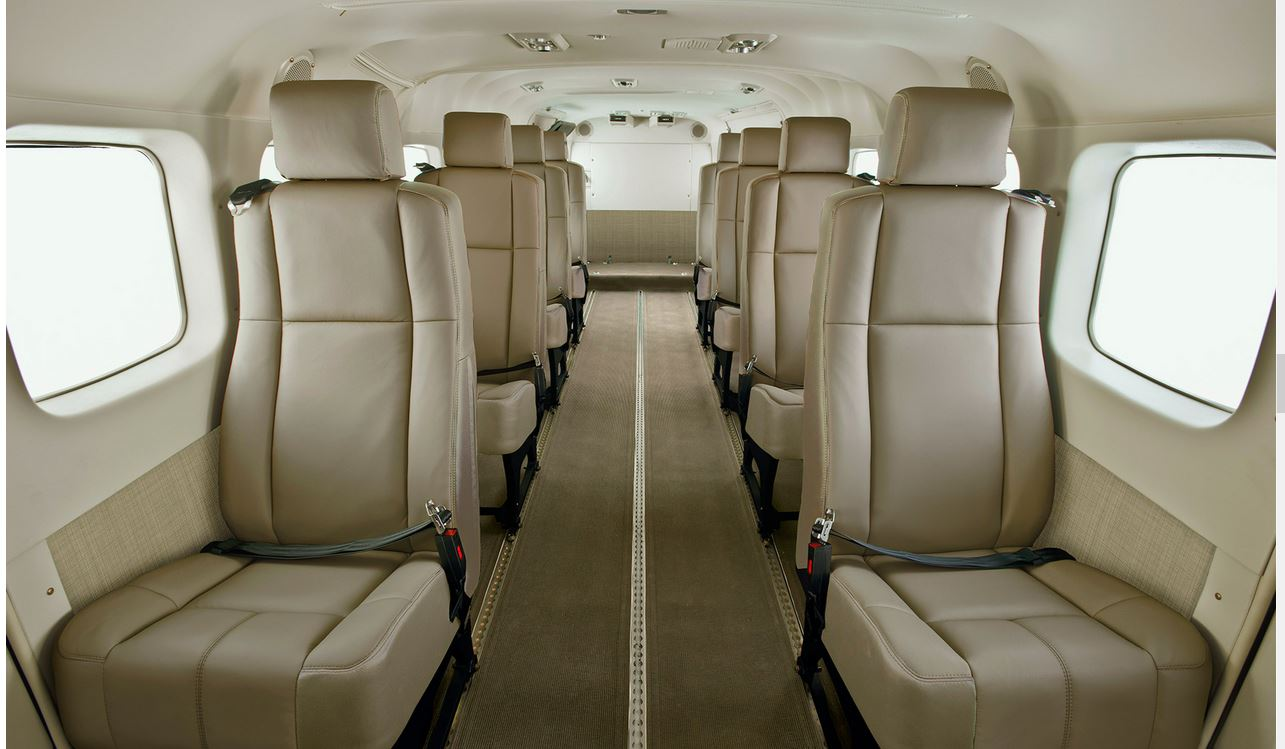

**Краткие характеристики самолёта Cessna Caravan:**

    Экипаж: один или два пилота
    Вместимость: 9  или 13 пассажиров с отказом от требований FAR Part 23 
    Длина: 11,46 м 
    Размах: 15,87 м 
    Высота: 4,53 м 

    Пустой вес: 2145 кг 
    Полная масса: 3629 кг 

    Максимальная посадочная масса: 3538 кг 
    Запас топлива: 1009 кг / 1257 л 

    Высота салона: 1,37 м 
    Ширина салона: 1,63 м 

    Силовая установка: 1 турбовинтовой Pratt & Whitney Canada PT6A -114A, 675 л.с. (503 кВт) 
    Гребные винты: 3-лопастные McCauley с постоянной скоростью, полное флюгирование, изменяемый шаг 


    Максимальная скорость: 352км./ч.
    Крейсерская скорость: 341км./ч.
    Потолок: 4200м
    Дальность полета с максимальной загрузкой: 1200км.

    Длина разбега: 585м.


Источник:

* Официальный производитель Textron Aviation https://cessna.txtav.com/en/turboprop/caravan#_model-specs
* Cessna 208 Дом на колесах - https://ru.abcdef.wiki/wiki/Cessna_208_Caravan
* Подробнее на: https://avia.pro/blog/cessna-208-caravan

#### 3.3.2. Базовая модель семейства канадских региональных реактивных самолетов _Bombardier CRJ-200_

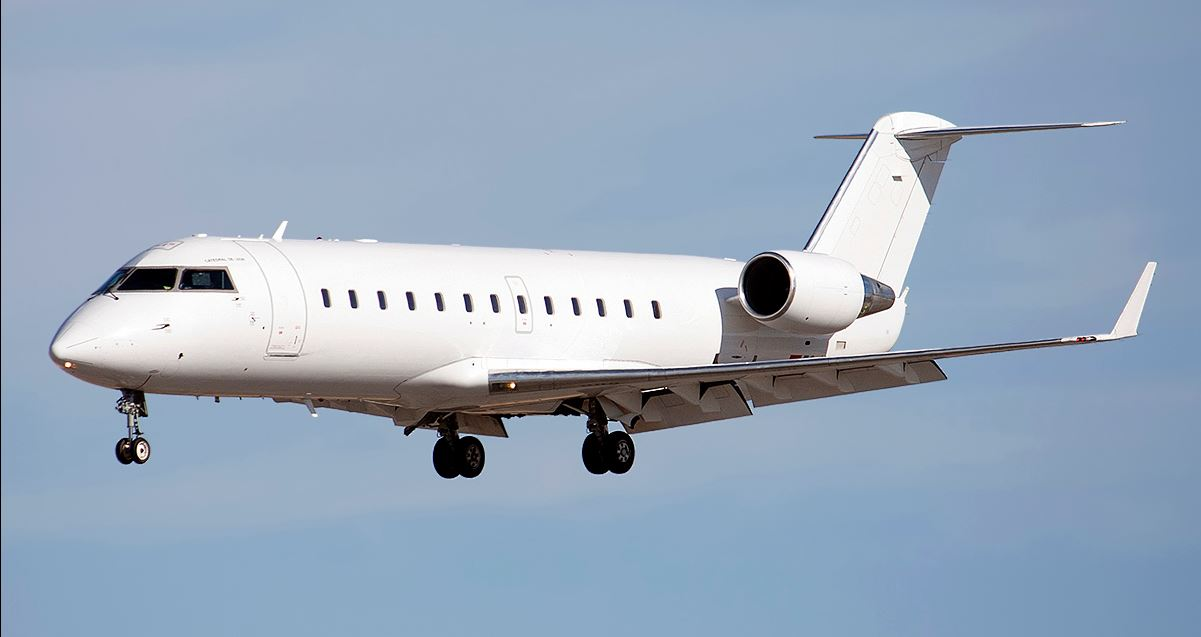

Вид кабины пилота

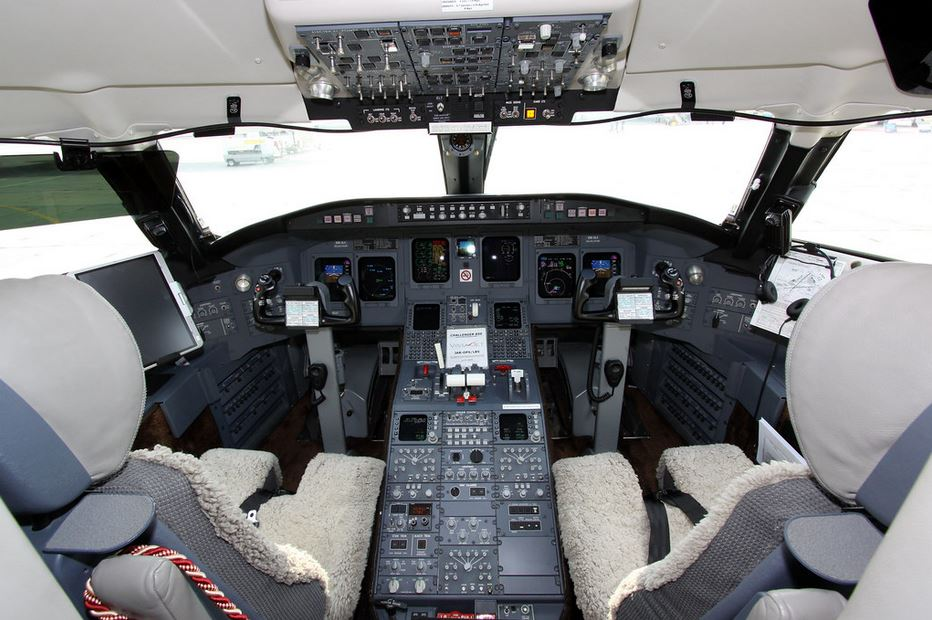

Вид пассажирского салона

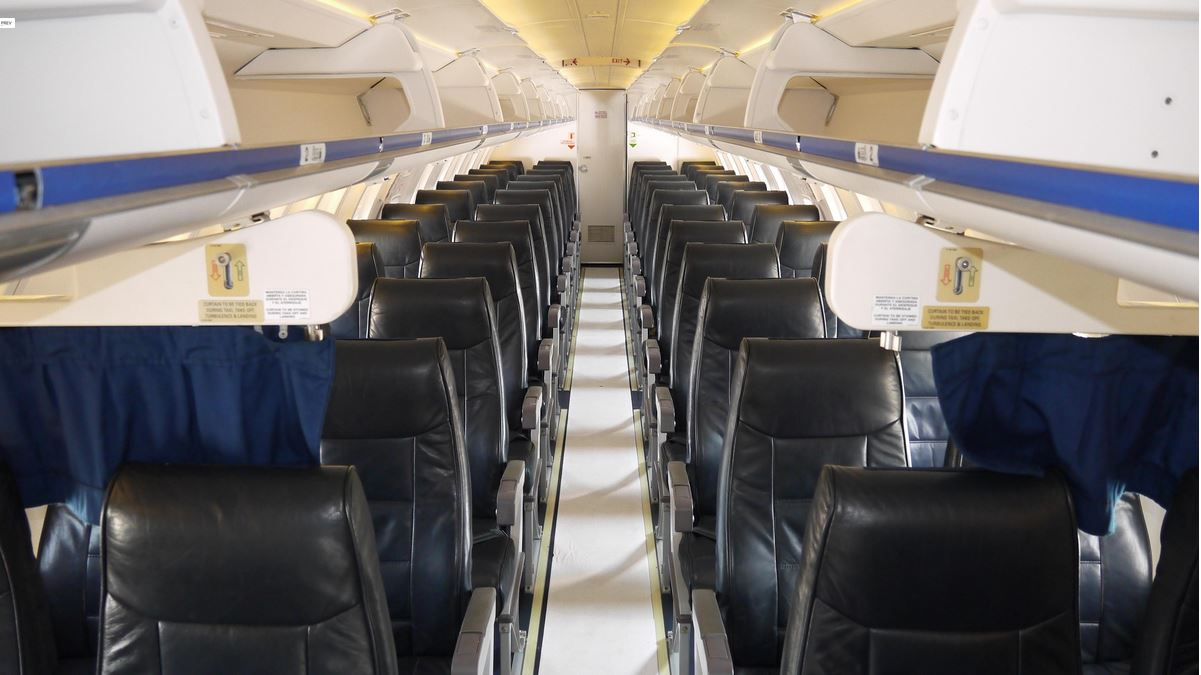

**Краткие характеристики самолёта Bombardier CRJ-200:**	
    
    Экипаж 3–4 (2 пилота + 1–2 бортпроводника)	
    Длина (м)	26.8	
    Размах крыла (м) 21.2	
    Высота (м)	6.2
    Площадь крыла (кв.м)	48.3	
    
    Вес

    Макс. взлетный вес (кг)	23 130	
    Макс. посадочный вес (кг)	21 320	
    Вес пустого (кг)	13 830	
    Макс. вес без топлива (кг)	19 960	
    Макс. коммерческая загрузка (кг)	6 120	

    Емкость топливных баков (л)	8 080	
    Макс. запас топлива (кг)		6 490

    Летные данные

    Дальность полета с макс. загрузкой (км)	2 500
    Макс. крейсерская скорость (км/ч)	790
    Максимальная скорость (км/ч)	860
    Потолок (макс. высота полета) (м)	12 500
    Длина разбега (м)	1 770
    Длина пробега (м)	1 480
    Двигатели	GE CF34-3B1 (2 x 4180 кгс) 41,01 кН

    Пассажирский салон

    Кол-во кресел (эконом)	50
    Шаг кресел эконом класса (см)	79
    Ширина салона (м)	2.55
    Высота салона (м)	1.85
    Ширина прохода (м)	0.41
    Ширина кресла эконом (м)	0.44

Источник:

https://www.airlines-inform.ru/commercial-aircraft/bombardier-crj-200.html

https://ru.wikipedia.org/wiki/Bombardier_CRJ200


#### 3.3.3. Российский ближнемагистральный узкофюзеляжный пассажирский самолёт _Sukhoi SuperJet-100_

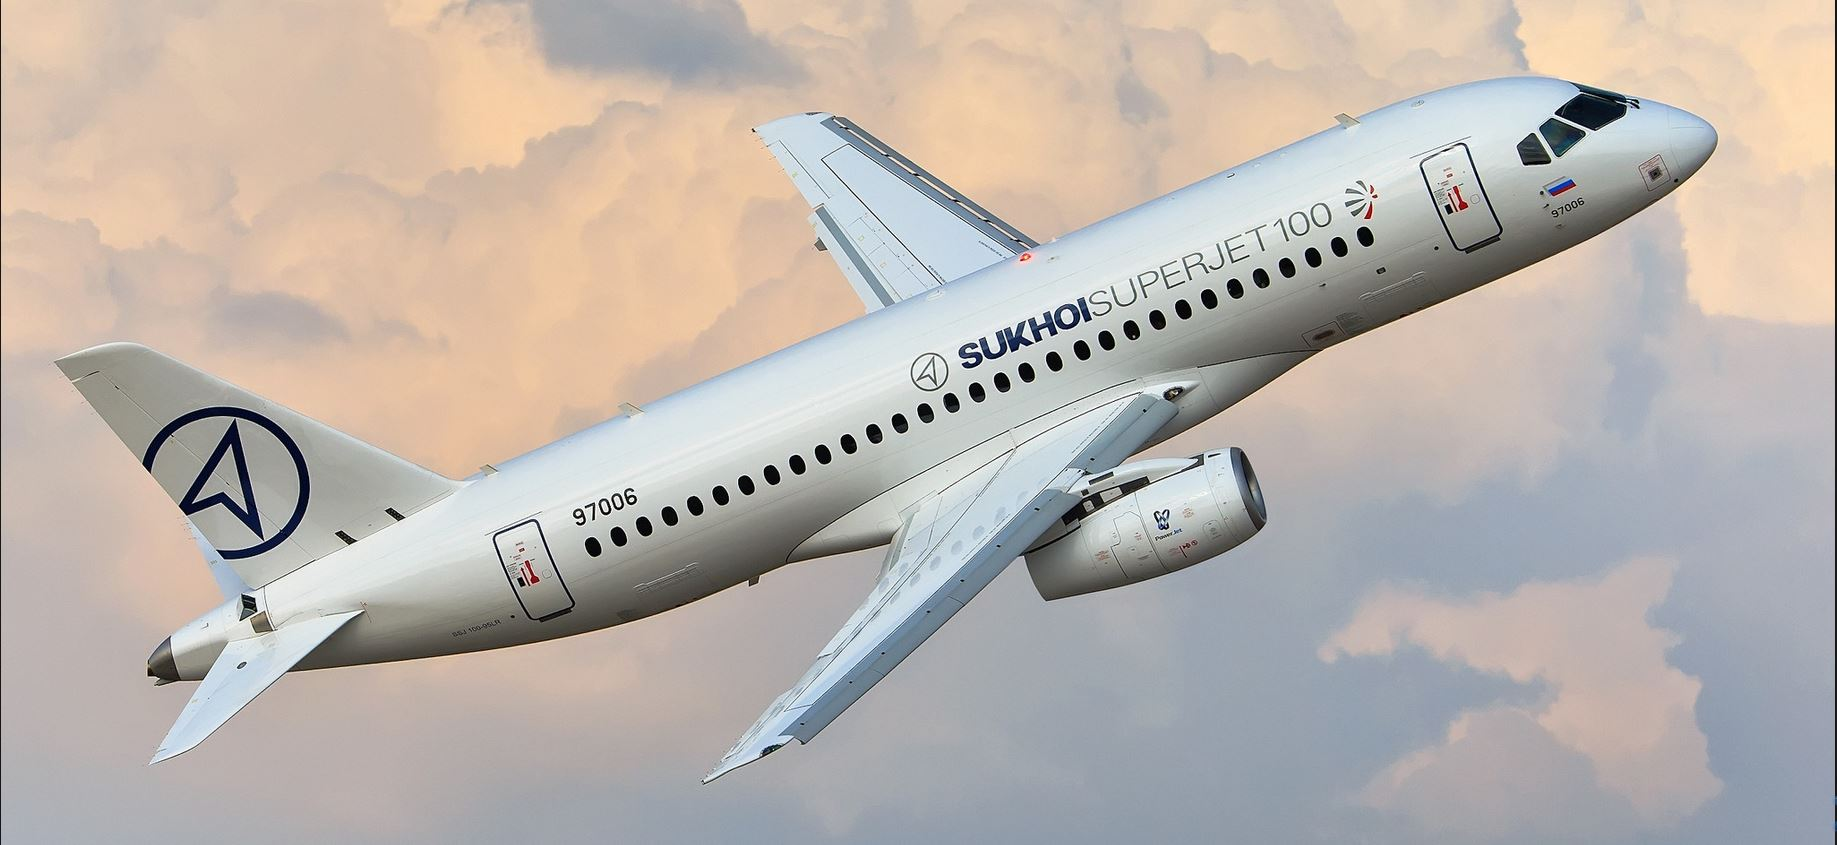

Вид кабины пилота

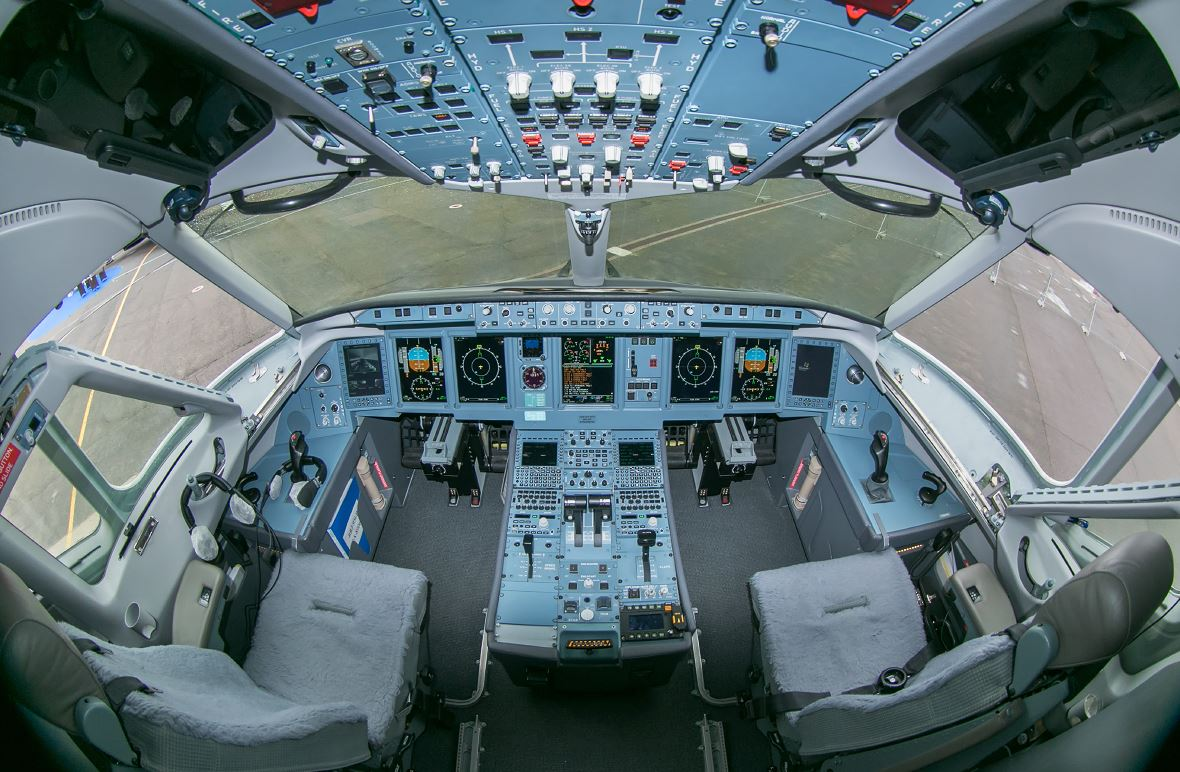

Вид пассажирского салона

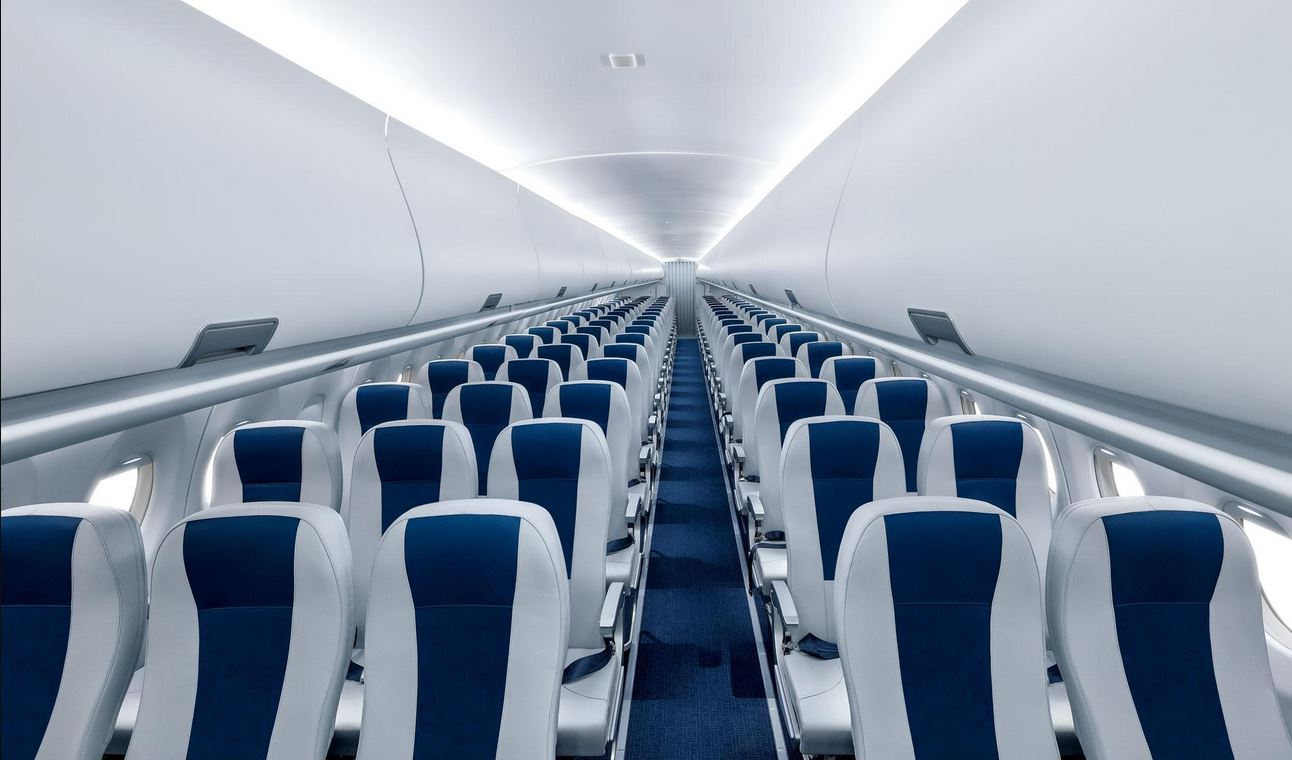

**Краткие характеристики базовой конфигурации самолёта Superjet 100:**


    число мест экипажа 4 (2 пилота, 2 бортпроводника)
    пассажирских  мест: 98 в базовой компоновке (до 108) 87 (12+75) в компоновке для компании Аэрофлот. 


    размах крыла (м) 27.8
    длина самолета (м) 29.940
    высота самолёта (м) 10.283

    база шасси (м) 11.249
    колея шасси (м) 5.74


    Основные характеристики двигателя:     тип SaM 146 количество двигателей 2

    Массовые характеристики:

    максимальная взлетная масса (т) 45.8
    максимальная масса при посадке (т) 41
    расчетная полезная нагрузка (т) 12.245

    Летно-технические характеристики:

    крейсерская скорость LRC, M 0.78 - 830 км/ч 
    дальность полета с полезной нагрузкой (км) 3,048
    максимальная высота полета (м) 12,200
    дальность полёта (км) 3048


	

Источник:

* ОАК (Объединенная авиастроительная компания) https://uacrussia.ru/ru/aircraft/lineup/civil/superjet-100/#aircraft-specific

* Sukhoi Superjet 100 https://ru.wikipedia.org/wiki/Sukhoi_Superjet_100


	



### 3.4. Дополнительный вывод

Исходя из технических данных сследует, что:
* лидер по количеству выполненных рейсов  **_Cessna 208 Caravan_** вмещает 9 пассажиров и расчитан на 1 200 км. полета;
* второй по количеству рейсов **_Bombardier CRJ-200_** вмещает 50 пассажиров и расчитан на 2 500 км. полета;
* третий по количеству рейсов **_Sukhoi SuperJet-100_** вмещает 98 пассажиров и расчитан на 3 048 км. полета.

Наблюдаем обратную зависимость между количеством выполняемых рейсов, вместимостью и дальностью полета. 

## 4. Строим график "Города и количество рейсов"

Визуализируем график "Города и количество рейсов" с помощью библиотек **Matplotlib** и **Seaborn**. 

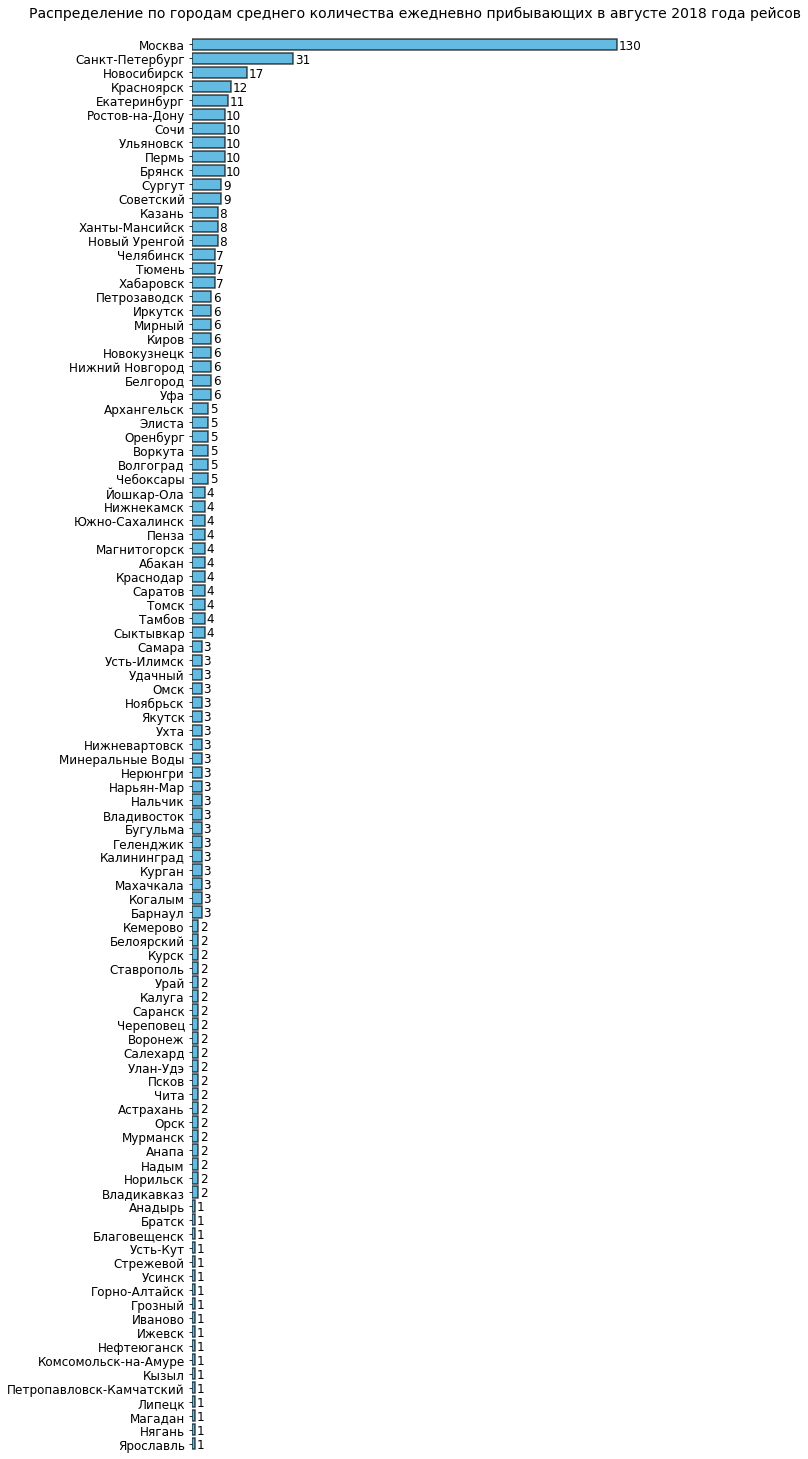

In [231]:
plt.figure(figsize=(8, 26))
ax = sns.barplot(x='average_flights', y='city', 
                 data = cities.sort_values(by='average_flights', ascending=False),
                 color='#03A9F4', ec='black', linewidth=1.5, alpha=0.7)
sns.despine(left=True, bottom=True,)
plt.title('Распределение по городам среднего количества ежедневно прибывающих в августе 2018 года рейсов', 
          y=1.01, 
          fontsize=14
          )
for i in ax.patches:
    ax.text(i.get_width()+0.5, i.get_y()+0.7, 
            str(int(i.get_width())), fontsize=12, color='black')
plt.xticks([])    
plt.yticks(fontsize=12)
plt.xlabel('')
plt.ylabel('')
plt.show()

### 4.1. Вывод:

Как видно из графика, наибольшее количество рейсов ежедневно прибывает в крупнейший в России транспортный хаб - Москва, в среднем 130 рейсов в день. На втором мете - Санкт-Петербург, с 31 прибывающим рейсом в день. Третье место за Новосибирском, с 17 рейсами в сутки. По остальным городам от 12 до 1 рейса. **Распределение имеет явный перекос в сторону европейской части России**, а еще конкретнее - в сторону двух столиц. 

## 5. Строим график "Топ 10 городов по количеству рейсов"

Составим список из 10 городов с наибольшим количеством прибывающих рейсов.

In [232]:
top_10_cities = cities.sort_values(
    by='average_flights', ascending=False
).head(10)

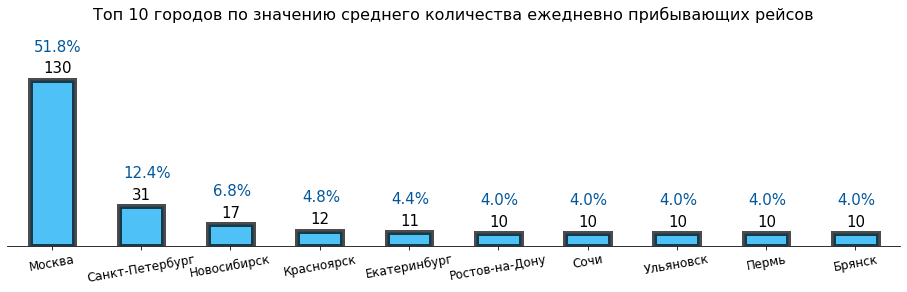

In [192]:
ax = top_10_cities.plot(
    kind='bar', x='city', y='average_flights', figsize=(16, 4), #grid= True, 
    color='#03A9F4', fontsize=14, alpha=0.7, ec='black', linewidth=5, legend=False)
plt.title('Топ 10 городов по значению среднего количества ежедневно прибывающих рейсов', 
          y=1.01, 
          fontsize=16
          )
sns.despine(left=True)

totals = []
for i in ax.patches:
    ax.text(i.get_x()+.15, i.get_height()+5,
            str(round((i.get_height()))), fontsize=15, color='black', rotation=0)
    totals.append(i.get_height())
total = sum(totals)
for i in ax.patches:
    ax.text(i.get_x()+.05, i.get_height()+22,
            str(round((i.get_height()/total)*100, 1))+'%', fontsize=15, color='#01579B')
plt.xlabel('', rotation=0, fontsize=14)
plt.xticks(rotation=10, fontsize=12)
plt.yticks([])
plt.ylim(0, 170)
plt.show()

### 5.1. Вывод:

* Ожидаемый лидер по приему рейсов из списка топ 10 - Москва, 130 рейсов в сутки.
* Второе место занимает  Санкт-Петербург, принимающий 31 рейс в сутки.
* Третье место занимает Новосибирск с приемом 17 рейсов в сутки.
* На четвертом месте Красноярск, принимающий 12 рейсов.
* Екатеринбург на пятом месте, с количеством ежедневно принимаемых рейсов равным 11.
* Остальные пять мест распределились между: Ростов-на-Дону, Пермь, Брянск, Сочи и Ульяновск, со средним значением принимаемых рейсов равным 10.

На Москву приходится почти 52 % от общего числа перелетов  из списка топ-10 городов. 

## 6. Дополнительные исследования

### 6.1 Построение карт Plotly Mapbox

Попробуем визуализировать данные набора **_query_3_** с помощью карт. Для этого получим координаты списка городов с реализовав **_API_** запрос на внешний ресурс **_Яндекс.Геокодер_**
В нашем случае, необходимо получить координаты по 101 городу.

Напишем цикл формирования запросов по данным городов. В начале цикла укажем данные ключа и адреса, куда будут уходить запросы.

* **Примечание**:

**Для проверки исполнения кода необходимо перевести окно из Markdown в Код и указать свой API-key.** 

In [193]:
# запускаем функцию

key = '2f09d139-c7c2-440b-abb9-4c73c0939c64'#'указать свой API-key '
url = 'https://geocode-maps.yandex.ru/1.x/?apikey='

#зададим параметры запроса, чтобы получать в ответ на запрос json - файл

params = { ## словарь с параметрами запроса
    "format" : "json", ## определяем формат ответа на запрос
}

#координаты будем получать в виде отдельных файлов latitudes (широта) и longitudes (долгота).
#Создадим переменные:  latitudes, longitudes и districts

latitudes = []
longitudes = []

for city in cities['city']:
    if city == city: # чтоб не столкнуться с nan
        url = 'https://geocode-maps.yandex.ru/1.x/?apikey=' + key + '&geocode=' + city
        #url_formatted = url + city
        response = requests.get(url, params=params)
        try:
            #получим координаты точки
            coord = response.json()['response']['GeoObjectCollection']['featureMember'][0]['GeoObject']['Point']['pos']
        
        except:# если результат не получаем, то идем далее по циклу
            pass
        if coord is not None:  # если ответ есть
            latitude = float(coord.split()[1])
            longitude = float(coord.split()[0])
            latitudes.append(latitude)
            longitudes.append(longitude)
        else:  ## если ответа не было
            latitudes.append('')
            longitudes.append('')

Добавим координаты в наш набор

In [233]:
cities['longitude'] = longitudes
cities['latitude'] = latitudes

Проверим наличие координат в наборе

In [234]:
cities.sample(5)

,city,average_flights,longitude,latitude
75,Ставрополь,2,41.969110,45.043317
87,Усть-Илимск,3,102.741532,57.943044
41,Минеральные Воды,3,43.138340,44.208806
21,Иваново,1,40.973930,57.000353
28,Кемерово,2,86.086847,55.355198


Исследуемые данные содержат недостаточно инормации, восполним этот пробел и получим из внешнего источника дополнительную информацию о числе проживающих в городах.

In [235]:
populations = pd.read_csv('https://raw.githubusercontent.com/hflabs/city/master/city.csv')

In [236]:
populations.head(3)

,address,postal_code,country,federal_district,region_type,region,area_type,area,city_type,city,...,fias_level,capital_marker,okato,oktmo,tax_office,timezone,geo_lat,geo_lon,population,foundation_year
0,"Респ Адыгея, г Адыгейск",385200.0,Россия,Южный,Респ,Адыгея,NaN,NaN,г,Адыгейск,...,4,0,79403000000,79703000001,107,UTC+3,44.878414,39.190289,12689,1969
1,г Майкоп,385000.0,Россия,Южный,Респ,Адыгея,NaN,NaN,г,Майкоп,...,4,2,79401000000,79701000001,105,UTC+3,44.609827,40.100661,144055,1857
2,г Горно-Алтайск,649000.0,Россия,Сибирский,Респ,Алтай,NaN,NaN,г,Горно-Алтайск,...,4,2,84401000000,84701000001,400,UTC+7,51.958103,85.960324,62861,1830


Проверим набор **_populations_** на предмет пропусков в столбце **_'city'_**

In [237]:
populations[populations.city.isna()]

,address,postal_code,country,federal_district,region_type,region,area_type,area,city_type,city,...,fias_level,capital_marker,okato,oktmo,tax_office,timezone,geo_lat,geo_lon,population,foundation_year
509,г Москва,101000.0,Россия,Центральный,г,Москва,NaN,NaN,NaN,NaN,...,1,0,45000000000,45000000,7700,UTC+3,55.754047,37.620405,11514330,1147
517,"Московская обл, г Воскресенск",140200.0,Россия,Центральный,обл,Московская,г,Воскресенск,NaN,NaN,...,3,0,46410000000,46710000001,5005,UTC+3,55.307152,38.702795,91301,1862
522,"Московская обл, г Дмитров",141800.0,Россия,Центральный,обл,Московская,г,Дмитров,NaN,NaN,...,3,0,46415000000,46715000001,5007,UTC+3,56.347746,37.526672,61454,1154
532,"Московская обл, г Истра",143500.0,Россия,Центральный,обл,Московская,г,Истра,NaN,NaN,...,3,0,46433000000,46733000001,5017,UTC+3,55.906227,36.860145,35106,1589
534,"Московская обл, г Клин",141601.0,Россия,Центральный,обл,Московская,г,Клин,NaN,NaN,...,3,0,46437000000,46737000001,5020,UTC+3,56.342560,36.724003,80584,1317
552,"Московская обл, г Наро-Фоминск",143300.0,Россия,Центральный,обл,Московская,г,Наро-Фоминск,NaN,NaN,...,3,0,46450000000,46750000001,5030,UTC+3,55.386185,36.734484,64640,1840
553,"Московская обл, г Ногинск",142400.0,Россия,Центральный,обл,Московская,г,Ногинск,NaN,NaN,...,3,0,46451000000,46751000001,5031,UTC+3,55.868613,38.462210,99762,1389
554,"Московская обл, г Одинцово",143000.0,Россия,Центральный,обл,Московская,г,Одинцово,NaN,NaN,...,3,0,46455000000,46755000001,5032,UTC+3,55.678945,37.263686,139021,1470
556,"Московская обл, г Орехово-Зуево",142600.0,Россия,Центральный,обл,Московская,г,Орехово-Зуево,NaN,NaN,...,3,0,46457000000,46757000001,5034,UTC+3,55.815142,38.986982,120620,1917
567,"Московская обл, г Сергиев Посад",141300.0,Россия,Центральный,обл,Московская,г,Сергиев Посад,NaN,NaN,...,3,0,46428000000,46728000001,5042,UTC+3,56.306255,38.150266,110878,1337


Наблюдаем в списке три города федерального  значения: Москва, СПб и Севастополь. Нас интересуют Москва и СПб, т.к. они входят в список городов набора **_cities_**. Заменим пропуски в двух строках вручную.

In [238]:
populations.loc[509, 'city'] = 'Москва'
populations.loc[786, 'city'] = 'Санкт-Петербург'

Выполним проверку

In [239]:
populations.query('city == "Санкт-Петербург" | city == "Москва"')

,address,postal_code,country,federal_district,region_type,region,area_type,area,city_type,city,...,fias_level,capital_marker,okato,oktmo,tax_office,timezone,geo_lat,geo_lon,population,foundation_year
509,г Москва,101000.0,Россия,Центральный,г,Москва,NaN,NaN,NaN,Москва,...,1,0,45000000000,45000000,7700,UTC+3,55.754047,37.620405,11514330,1147
786,г Санкт-Петербург,190000.0,Россия,Северо-Западный,г,Санкт-Петербург,NaN,NaN,NaN,Санкт-Петербург,...,1,0,40000000000,40000000,7800,UTC+3,59.939131,30.315900,4848742,1703


Создадим набор **_all_city_data_**, который будет содержать данные о городах, количестве принимаемых рейсов, координатах и  численности населения. 

In [240]:
all_city_data = cities.merge(populations[['city', 'population']], left_on='city', right_on='city')

In [241]:
all_city_data

,city,average_flights,longitude,latitude,population
0,Абакан,4,91.442396,53.721152,165183
1,Анадырь,1,177.518913,64.735814,13053
2,Анапа,2,37.316152,44.894939,58983
3,Архангельск,5,40.515762,64.539911,348716
4,Астрахань,2,48.030178,46.347614,520662
...,...,...,...,...,...
99,Чита,2,113.501049,52.033635,323964
100,Элиста,5,44.269759,46.307743,103728
101,Южно-Сахалинск,4,142.729587,46.957771,181727
102,Якутск,3,129.732178,62.027221,269486


Для выделения на карте городов - лидеров по перелетам, добавим в набор данных  **_all_city_data_** столбец **_'category'_** в который поместим для топ-10 городов значение 10, для остальных городов -1. 

In [242]:
def flight_rank(row):
    if row['average_flights'] <= 9:
        return 1
    else:
        return 10
all_city_data['category'] = all_city_data.apply(flight_rank, axis=1)

Для выполнения расчетов с долями от общего числа перелетов, добавим столбец **_'rate'_**, в который поместим отношение количества принимаемых каждым городом к общему числу рейсов.

In [243]:
all_city_data['rate'] = (all_city_data['average_flights'] / all_city_data['average_flights'].sum() * 100).round(1)

Отсортируем набор по убыванию значений принимаемых рейсов и обновим индексацию.

In [244]:
all_city_data = all_city_data.sort_values(by='average_flights', ascending=False).reset_index(drop=True)

In [245]:
all_city_data.head(10)

,city,average_flights,longitude,latitude,population,category,rate
0,Москва,130,37.622513,55.753220,11514330,10,22.9
1,Санкт-Петербург,31,30.315644,59.938955,4848742,10,5.5
2,Новосибирск,17,82.920430,55.030204,1498921,10,3.0
3,Красноярск,12,92.852572,56.010569,973826,10,2.1
4,Екатеринбург,11,60.597474,56.838011,1377738,10,1.9
5,Ростов-на-Дону,10,39.720358,47.222078,1091544,10,1.8
6,Пермь,10,56.229443,58.010455,1000679,10,1.8
7,Брянск,10,34.363425,53.243562,415640,10,1.8
8,Сочи,10,39.723098,43.585472,343285,10,1.8
9,Ульяновск,10,48.403132,54.314192,613793,10,1.8


Посмотрим соотношение количества рейсов, принимаемых лидерами к принимаемым остальными городами.

In [246]:
print()
print('Общее количество всех принимаемых рейсов: {}'. format(all_city_data['average_flights'].sum()))
print('Количество принимаемых рейсов городами лидерами: {}'. format(all_city_data['average_flights'][0:9].sum()),
     ', что cоcтавляет - {:.0f} %'.format(all_city_data['rate'][0:9].sum()))
print('Количество принимаемых остальными городами рейсов: {}'. format(all_city_data['average_flights'][10:].sum()),
     ', что cоcтавляет - {:.0f} %'.format(all_city_data['rate'][10:].sum()))
print()


Общее количество всех принимаемых рейсов: 567
Количество принимаемых рейсов городами лидерами: 241 , что cоcтавляет - 43 %
Количество принимаемых остальными городами рейсов: 316 , что cоcтавляет - 57 %



Построим карту с нанесением точек городов, перечисленных в нашем наборе **_all_city_data_**. Выделим лидеров из списка топ-10 размером маркера. Цвет маркера бдет зависеть от численности населения.

In [247]:
map_center = {
    'lat': all_city_data['latitude'].values[3], 
    'lon': all_city_data['longitude'].values[3]
}
labels = {
    'category' : 'категория',
    'latitude' : 'широта',
    'longitude' : 'долгота',
    "average_flights" : "Количество рейсов",
    #"city" : "Город",
    "population" : "Население",
}
fig = px.scatter_mapbox(
    all_city_data, lat='latitude', lon='longitude', mapbox_style='open-street-map', 
    center=map_center, zoom=2,   color='population', range_color=[0, 1000000],
    category_orders=['average_flights', 'population'],
    size='category', size_max=12, opacity=0.9,
    labels=labels,
    title='Карта географии рейсов авиакомпании',
    hover_name='city',
    hover_data=['average_flights', 'population'],
)
fig.update_traces(showlegend=False)
fig.show()

### 6.2. Вывод:

Наблюдаем наибольшую концентрацию перелетов в Центральном, Южном, Приволжском и Уральском округах. Большую часть списка топ 10 городов занимают города миллионники, семь из десяти. Население Брянска и Сочи, по данным за 2018 год, составляло чуть больше 400 тыс. Ульяновск - 627 тыс. Исходя из исследуемого периода (июль - октябрь 2018 года), с учетом нахождения на территории Большого Сочи отдыхающих, можно и Сочи отнести к городу миллионнику. Аэропорты городов, указанных в списке топ 10, в сутки принимают 43 % общего числа ежедневных рейсов в масштабах РФ. Одна только Москва обслуживает в сутки больше, чем оставшиеся 9 городов из списка топ 10 - 52% против 48%. В разрезе всех городов, Москва принимает 23 % рейсов в сутки. Суммарное значение ежедневных перевозок по 9 городам сопоставимо со значением ежедневных рейсов, принимаемых Москвой, следовательно большая часть внутренних магистальных авиаперевозок пассажиров, осуществляется транзитом через аэропорты Москвы. Отсюда такое распределение по количеству принимаемых рейсов. Доля перелетов по городам, не вошедшим в список топ-10 превышает долю перелетов городов - лидеров, 57 % против 43 %. Можно предположить наличие связи между  количеством рейсов, выполненных моделью **_Cessna 208 Caravan_** и количеством рейсов, принимаемых городами, не входящими в топ-10.

### 6.3 Проверка достоверности данных о перелетах лидеров перевозок.

Изучим данные лидера перевозок - ближнемагистрального  узкофюзеляжного самолет **_Cessna Caravan_**.  

Попробуем получить из официальных источников данные по количеству зарегистрированных в  Государственном реестре гражданских воздушных судов РФ транспортных средств модели **_Cessna_**.

На ресурсе ( https://favt.gov.ru/opendata-table?id=2500 ) Федерального Агентства Воздушного Транспорта (Росавиация) имеется гиперссылка на версию 2018 года Госреестра гражданских воздушных судов РФ, в формате **csv**. По прямой ссылке не удалось выгрузить  непосредственно из первоисточника данные в блокнот. Скачал файл в формате **csv** на локальный диск. Импортировал набор данных в Goglesheets, открыл к нему доступ по ссылке. Загрузил данные в блокнот.

In [249]:
spreadsheet_id = '1pNaQY_VLcbcmY6U56SbtDyMsKBfXUhExxFh8bz5Dzyo'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)

In [250]:
fly_reestr = pd.read_csv(BytesIO(r.content))

In [252]:
fly_reestr

,Вид воздушного судна,Тип (наименование) воздушного судна,Опознавательные знаки,Серийный №,Идентификац. №,номер свидетельства о регистрации,дата действующего свидетельства о регистрации
0,самолет,Птенец-2,RA-0001A,NaN,ЕЭВС.03.1529,0001,11.03.2012
1,дельталет,Аватар,RA-0002A,NaN,ЕЭВС.03.1709,0002,16.03.2012
2,самолет,С-2 Елочка,RA-0002G,NaN,ЕЭВС.02.0126,0224,02.06.2006
3,дельталет,СОКОЛ,RA-0003A,NaN,ЕЭВС.03.1708,0003,16.03.2012
4,самолет,Небесный,RA-0003G,NaN,ЕЭВС.02.0013,0225,07.04.2008
...,...,...,...,...,...,...,...
8943,самолет,Ан-2,RA-96243,1Г7227,NaN,3628,06.08.1966
8944,самолет,Ан-2,RA-96247,1Г7231,NaN,3599,20.07.1966
8945,самолет,Ан-2,RA-96249,1Г7233,NaN,3600,20.07.1966
8946,самолет,Ан-2,RA-96252,1Г7236,NaN,3629,27.04.2012


Посмотрим на список названий столбцов

In [253]:
fly_reestr.columns.to_list()

['Вид воздушного судна',
 'Тип (наименование) воздушного судна',
 'Опознавательные знаки',
 'Серийный №',
 'Идентификац. №',
 'номер свидетельства о регистрации',
 'дата действующего свидетельства о регистрации']

Названия столбцов неудобные для сортировки, поэтому произведем их замену.

In [254]:
fly_reestr = fly_reestr.rename(
    columns={
        'Вид воздушного судна':'aircraft_type', 
        'Тип (наименование) воздушного судна':'model_name',
        'Опознавательные знаки':'id',
        'Серийный №':'serial_number',
        'Идентификац. №':'aircraft_namber',
        'номер свидетельства о регистрации':'certificate_number', 
        'дата действующего свидетельства о регистрации':'certificate_date'       
    }
)

Проверим названия

In [255]:
fly_reestr

,aircraft_type,model_name,id,serial_number,aircraft_namber,certificate_number,certificate_date
0,самолет,Птенец-2,RA-0001A,NaN,ЕЭВС.03.1529,0001,11.03.2012
1,дельталет,Аватар,RA-0002A,NaN,ЕЭВС.03.1709,0002,16.03.2012
2,самолет,С-2 Елочка,RA-0002G,NaN,ЕЭВС.02.0126,0224,02.06.2006
3,дельталет,СОКОЛ,RA-0003A,NaN,ЕЭВС.03.1708,0003,16.03.2012
4,самолет,Небесный,RA-0003G,NaN,ЕЭВС.02.0013,0225,07.04.2008
...,...,...,...,...,...,...,...
8943,самолет,Ан-2,RA-96243,1Г7227,NaN,3628,06.08.1966
8944,самолет,Ан-2,RA-96247,1Г7231,NaN,3599,20.07.1966
8945,самолет,Ан-2,RA-96249,1Г7233,NaN,3600,20.07.1966
8946,самолет,Ан-2,RA-96252,1Г7236,NaN,3629,27.04.2012


Приступим к выборке данных по интересующему нас самолету - **_Cessna 208B_**

In [256]:
fly_reestr.query('model_name == "Cessna 208B"')

,aircraft_type,model_name,id,serial_number,aircraft_namber,certificate_number,certificate_date
7971,самолет,Cessna 208B,RA-67422,208B2239,NaN,6718,22.04.2016
7975,самолет,Cessna 208B,RA-67430,208B2314,NaN,7019,11.07.2012
7978,самолет,Cessna 208B,RA-67434,208B2316,NaN,7020,11.07.2012
7979,самолет,Cessna 208B,RA-67435,208B2323,NaN,7021,11.07.2012
7989,самолет,Cessna 208B,RA-67450,208B2402,NaN,7134,13.10.2016
8146,самолет,Cessna 208B,RA-67707,208В1273,NaN,6125,18.12.2007
8155,самолет,Cessna 208B,RA-67720,208В2178,NaN,6699,30.03.2016


Получается, что на октябрь 2018 года в реестре зарегистрировано всего 7 единиц данной модели. Возможно, что в реестре есть модели без указания номера. Проверим это. Отсортируем набор по строкам, содержащим в столбце **_'model_name'_** слово **_'Cessna '_**, результат поместим в переменную **_'aircraft_cessna'_**.  Используя метод **_value_counts()_** и параметр **_normalize=False_**, подсчитаем количество зарегистрированных модификаций модели **_Cessna_**.

In [257]:
aircraft_cessna = fly_reestr[fly_reestr['model_name'].str.contains("Cessna ")].reset_index(drop=True)
aircraft_cessna

,aircraft_type,model_name,id,serial_number,aircraft_namber,certificate_number,certificate_date
0,самолет,Cessna 172S,RA-1000G,NaN,ЕЭВС.03.0831,1083,11.04.2018
1,самолет,Cessna 172RG,RA-1614G,NaN,ЕЭВС.03.1666,1622,03.12.2015
2,самолет,Cessna 172E,RA-1834G,NaN,ЕЭВС.03.1893,1840,21.08.2012
3,самолет,Cessna C-172G,RA-1907G,NaN,ЕЭВС.03.1907,1903,04.12.2012
4,самолет,Cessna 172 BSV,RA-1912G,NaN,ЕЭВС.03.2056,1909,21.04.2017
...,...,...,...,...,...,...,...
179,самолет,Cessna 208B,RA-67707,208В1273,NaN,6125,18.12.2007
180,самолет,Cessna 172S,RA-67711,172S10566,NaN,6170,18.11.2009
181,самолет,Cessna 172S,RA-67712,NaN,ЕЭВС.08.0027,6171,30.03.2017
182,самолет,Cessna 172S,RA-67719,172S10399,NaN,6442,20.03.2015


Всего в реестре содержится 184 записи, в которых фигурирует **_Cessna_**, 184 модели разной модификации.

In [258]:
aircraft_cessna['model_name'].value_counts(normalize=False).reset_index()

,index,model_name
0,Cessna 172S,109
1,Cessna 208B,7
2,Cessna 172N,6
3,Cessna T206H,5
4,Cessna 182P,4
5,Cessna T182T,3
6,Cessna C-172G,2
7,Cessna 525 Citation Jet,2
8,Cessna 172M,2
9,Cessna 150 M,2


Преобладающее большинство  четырехместных моделей **_Cessna 172_** (131 единица), четырехместных моделей **_Cessna 182_** - 12 единиц, шестиместных моделей **_Cessna 206_** - 6 единиц. Интересующих нас 14-местных моделей  **_Cessna 208_** в реестре зарегистрировано всего 7 единиц.

Предположим, что все 4557 рейсов, осуществленные в сентябре 2018 годы, были выполнены силами этих 7  единиц.
Посчитаем количество ежедневных рейсов, приходящихся на эти 7 единиц:
 (4557 / 30 (дней в сентябре) = 151,9 вылетов в сутки)/ 7 единиц = 21,7 вылетов в сутки на одну единицу.

С учетом времени предполетной подготовки(заправки, техосмотра), загрузки пассажиров, взлета и посадки, исходя из технических характеристик (дальность полета, скорость полета, расход топлива), данное предположение  выглядят маловероятным. Наиболее вероятной представляется версия о приобретении авиакомпанией большей части (а может и всего) парка самолетов **_Cessna 208_** в лизинг у зарубежного владельца.

## 7. Общий вывод

Опираясь на данные, полученные в результате исследования в сентябре 2018 года, на внутренних перевозках наибольшее число вылетов было выполнено следующими моделями самолетов:
1. Cessna 208 Caravan - 4557 рейсов (макс - 13 пассажиров, предельная дальность - 1200км.)
2. Bombardier CRJ-200 - 4446 рейсов (макс - 50 пассажиров, предельная дальность - 2500км.)
3. Sukhoi SuperJet-100 - 4185 рейсов (макс - 98 пассажиров, предельная дальность - 3048км.)

Просматривается обратная зависимость между вместимостью  и дальностью полета самолета и количеством выполняемых рейсов. Вероятнее всего, лидерство красавцу **Cessna 208 Caravan** обеспечили региональные перелеты из городов, не входящих в топ -10,  либо ресурсодобывающие компании, осуществляющие доставку персонала к местам разработки на чартерных рейсах.

В распределении по среднему количеству ежесуточно принимаемых рейсов лидирует Москва - крупнейший транзитный транспортный хаб (3 основных аэропорта: Домодедово, Шереметьево и Внуково, 3 вспомогательных аэропорта: Жуковский, Остафьево и Чкаловский). Список далее:

1.  Москва 	130 рейсов в сутки.
2. 	Санкт-Петербург 	31 	рейс в сутки.
3. 	Новосибирск 	17 	рейсов в сутки.
4. 	Красноярск 	12 	рейсов в сутки.
5. 	Екатеринбург 	11 рейсов в сутки.
6. 	Ростов-на-Дону 	10 рейсов в сутки.
7. 	Пермь 	10 рейсов в сутки.
8. 	Брянск 	10 рейсов в сутки.
9. 	Сочи 	10 рейсов в сутки.
10.	Ульяновск 	10 	рейсов всутки.


Если обратимся к статистике рекламодателей ( https://www.avia-adv.ru/placement/airports/passenger-traffic.htm#placement_3 ), то список лидеров 2018 года по пассажиропотоку немного изменится и будет выглядеть следующим образом:
1. Безусловно - Москва с пассажиропотоком в 97 млн. в год.
2. Санкт-Петербург - 18 млн. в год.
3. Сочи - 6,3 млн. в год.
4. Екатеринбург - 6,1 млн. в год.
5. Новосибирск - 5,9 млн. в год.
6. Симферополь - 5,1 млн. в год.
7. Краснодар - 4,1 млн. в год.
8. Уфа - 3,2 млн. в год. 
9. Ростов-на-Дону - 3,2 млн. в год.
10. Казань - 3,1 млн. в год.

Несмотря на разные статистики, мы можем наблюдать наличие в обоих списках большей части городов из топ-10, что является признаком работы авиакомпании на линиях популярных направлений. 